# Movie Recommendation Model
In this project we will create a movie recommendation model, which will use colaborative filtering (if user A and B like movies X, Y, and Z, they have similar tastes, meaning if user A also enjoys movie V, user B will likely also enjoy movie V).

We will use fast.ai for our model, which is built ontop of the PyTorch library.

## Import modules

In [ ]:
import pandas as pd
from fastai.collab import *
from fastai.tabular.all import *

## Explore the data

This is a smaller version of the MovieLens 25M Dataset, meant for personal and educational use.

"This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018."

In [ ]:
# Inspect ratings dataset
path = "data/ratings.csv"
ratings = pd.read_csv(path)

print(len(ratings))
ratings.head()

100836


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Here we see how each user rated a particular movie

In [ ]:
# Inspect Movies dataset
path = "data/movies.csv"
movies = pd.read_csv(path, usecols=(0,1))

print(len(movies))
movies.head()

9742


,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we have our list of movies

In [ ]:
# Now we merge the datasets, and convert into a Collaborative filtering dataloader for fast.ai
ratings = ratings.merge(movies)
dls = CollabDataLoaders.from_df(ratings, item_name = 'title', bs = 64)
dls.show_batch()

,userId,title,rating
0,372,Things to Do in Denver When You're Dead (1995),2.0
1,20,Wild Wild West (1999),1.0
2,111,Denis Leary: No Cure for Cancer (1993),2.5
3,122,Raising Arizona (1987),5.0
4,256,"Patriot, The (2000)",4.0
5,599,"Gold Rush, The (1925)",3.0
6,331,Live Free or Die Hard (2007),3.0
7,414,Tape (2001),4.0
8,211,"Matrix Revolutions, The (2003)",1.0
9,591,House on Haunted Hill (1999),1.0


## Make first model

In [ ]:
# Initialise number of latent factors for user and movie
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])
n_factors = 5
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

**What is a latent factor?** -
A latent factor is a hidden characteristic or feature that is inferred from the data, which captures the underlying patterns.This is chosen as a hyperparameter, and can be optimised.

In [ ]:
# Create learnable model parameters
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0,0.1))

Here we create learnable model parameters. Out initial values are drawn from a normal distribution. This is usually used when initialising weights and biases for layers in a neural network. The * operator us used to unpack the dimensions from the size tuple.


Inspiration from:

https://medium.com/@adachoudhry26/getting-started-with-ai-building-a-movie-recommendation-model-from-scratch-c3858d8948b

In [ ]:
# Create our model
# Model produces a predicted score/rating for each user-movie pair in batch
class DotProductBias(Module):  # Inherits Module

  def __init__(self, n_users, n_movies, n_factors, y_range = (0, 5.5)):
    # Create factors and biases
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users]).
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self,x):  # Forward propagation
    # Retrieve latent factors (embedding vectors)
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    # Combine info from both factors, could represent predicted preference
    res = (users*movies).sum(dim=1)
    # User and movie bias are retrieved, added to sum/predicted preference
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    # Return sigmoid range, ensure ratings are between 0 and 5.
    # y_range 5.5 chosen as the higher range produced better results
    return sigmoid_range(res, *self.y_range)

In [ ]:
# Create model and train, using mean-squared-error
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls , model , loss_func= MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd = 0.1) # wd = weight decay/L2 regularization, to reduce overfitting

epoch,train_loss,valid_loss,time
0,0.879559,0.855560,00:18
1,0.686203,0.730752,00:20
2,0.486295,0.730126,00:21
3,0.319022,0.731733,00:21
4,0.214560,0.733292,00:32


The weight decay / L2 regularization, adds to loss function the sum of all the weights squared, encouraging weights to be as small as possible.

In [ ]:
# Which movies are bad, aka which movies have lowest bias
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Karate Kid, Part III, The (1989)',
 'Speed 2: Cruise Control (1997)',
 'Catwoman (2004)',
 'Nutty Professor II: The Klumps (2000)',
 'Dungeons & Dragons (2000)']

In [ ]:
# Movies with high bias, aka best
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Usual Suspects, The (1995)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Goodfellas (1990)']

## Fast.ai version of first model

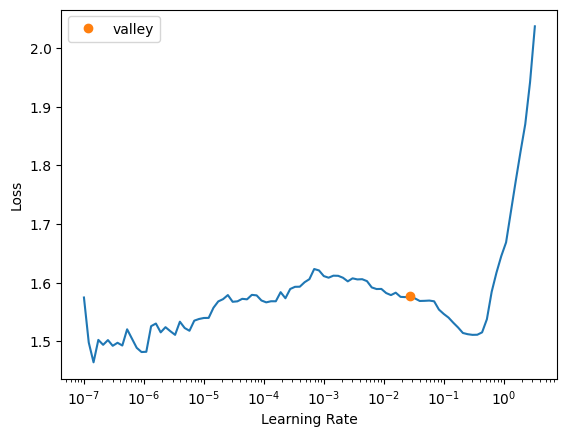

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), wd=0.1)  # add weight decay
suggested_lr = learn.recorder.lr_find()[0]  # Find good learning rate

In [ ]:
learn.fit_one_cycle(5, suggested_lr)

epoch,train_loss,valid_loss,time
0,0.996008,0.993831,00:20
1,0.990857,0.962555,00:20
2,0.866526,0.862485,00:23
3,0.678479,0.749444,00:21
4,0.355432,0.740338,00:20


In [ ]:
learn.show_results()

,userId,title,rating,rating_pred
0,159.0,3657.0,4.5,3.102726
1,480.0,4870.0,1.0,2.576189
2,68.0,591.0,2.5,3.321518
3,603.0,1694.0,5.0,3.160978
4,489.0,1135.0,5.0,3.948606
5,365.0,9338.0,1.5,2.786100
6,7.0,7681.0,5.0,4.244803
7,312.0,8205.0,5.0,4.165337
8,182.0,4986.0,4.5,3.561599
